In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"]= "/content/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()

spark-3.0.1-bin-hadoop2.7/
spark-3.0.1-bin-hadoop2.7/RELEASE
spark-3.0.1-bin-hadoop2.7/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/
spark-3.0.1-bin-hadoop2.7/examples/src/main/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/FPGrowthExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/GBTExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/ALSExample.scala
spark-3.0.1-bin-hadoop2.7/examples/src/main/scala/org/apache/spark/examples/ml/KMeansExample.scala
spark-3.0.1-bin-hadoop2.7/example

In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

In [3]:
spark.read.csv("MsCustomer.csv", header = True).createOrReplaceTempView("customers")
spark.read.csv("MsDriver.csv", header = True).createOrReplaceTempView("drivers")
spark.read.csv("MsFood.csv", header = True).createOrReplaceTempView("foods")
spark.read.csv("MsRestaurant.csv", header = True).createOrReplaceTempView("restaurants")
spark.read.csv("TransactionDetail.csv", header = True).createOrReplaceTempView("transaction_details")
spark.read.csv("TransactionHeader.csv", header = True).createOrReplaceTempView("transaction_headers")

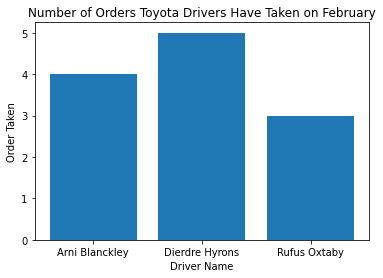

In [ ]:
# a.	Show how many orders JrebFood drivers who drived using Toyota
#      have taken in February using barplot.

data = spark.sql("""
SELECT d.DriverName as name, COUNT(th.transactionid) as count
FROM drivers d
JOIN transaction_headers th ON d.driverid = th.driverid
WHERE MONTH(th.TransactionDate) = 2 AND d.DriverVehicle LIKE ('Toyota')
GROUP BY d.DriverName 
""").toPandas()

plt.bar(data["name"], data["count"])
plt.title("Number of Orders Toyota Drivers Have Taken on February")
plt.xlabel("Driver Name")
plt.ylabel("Order Taken")
plt.show()

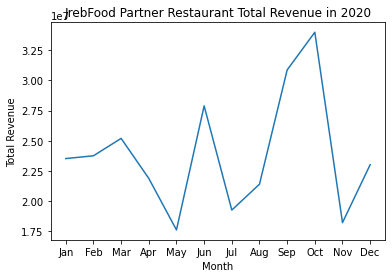

In [8]:
# b.	Show JrebFood partner restaurant revenue 
#     for every month in 2020 using line plot.'

data = spark.sql("""
  Select 
    case 
      when month(th.transactiondate) = 1 then 'Jan'
      when month(th.transactiondate) = 2 then 'Feb'
      when month(th.transactiondate) = 3 then 'Mar'
      when month(th.transactiondate) = 4 then 'Apr'
      when month(th.transactiondate) = 5 then 'May'
      when month(th.transactiondate) = 6 then 'Jun'
      when month(th.transactiondate) = 7 then 'Jul'
      when month(th.transactiondate) = 8 then 'Aug'
      when month(th.transactiondate) = 9 then 'Sep'
      when month(th.transactiondate) = 10 then 'Oct'
      when month(th.transactiondate) = 11 then 'Nov'
      when month(th.transactiondate) = 12 then 'Dec'
    end
       as month,
    sum(f.foodprice*td.quantity) as revenue,
    r.ispartner
    
  From restaurants r
  JOIN transaction_headers th
  ON th.restaurantid = r.restaurantid
  JOIN transaction_details td
  on th.transactionid = td.transactionid
  JOIN foods f
  ON td.foodid = f.foodid
  WHERE YEAR(th.TransactionDate) = '2020' and r.ispartner = 'TRUE'
  GROUP BY r.ispartner, month(th.transactiondate)
  ORDER BY month(transactiondate)
 """).toPandas()

plt.plot(data["month"], data["revenue"])
plt.title("JrebFood Partner Restaurant Total Revenue in 2020")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(range(0,12))
plt.show()

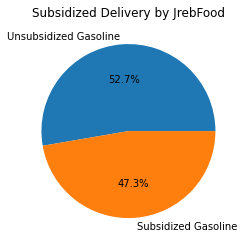

In [13]:
# c.	Show the percentage of deliveries that JrebFood subsidize using pie plot. 
#     The delivery will be subsidized based on the distance of the delivery as follows:
#     Delivery Distance	Benefit
#     > Average Distance of All Deliveries in January	Subsidized Gasoline
#     <= Average Distance of All Deliveries in January	Unsubsidized Gasoline

data = spark.sql("""
select 
mark, count(*) as total 
from(
  select distance,
    case 
    when distance > (select avg(distance) from transaction_headers where month(transactiondate) = 1) THEN 'Subsidized Gasoline'
    when distance <= (select avg(distance) from transaction_headers where month(transactiondate) = 1) THEN 'Unsubsidized Gasoline'
    end as mark
    from transaction_headers th
)
group by mark
""").toPandas()

plt.pie(data["total"], labels=data["mark"], autopct="%.1f%%")
plt.title("Subsidized Delivery by JrebFood")
plt.show()

In [14]:
# CLASSIFICATION

testing = spark.read.csv("Storm_Testing.csv", header = True, inferSchema= True)
training = spark.read.csv("Storm_Training.csv", header = True, inferSchema= True)

columns = ["wind_speed", "sky_color", "temperature", "storm_coming"]

testing.na.drop()
training.na.drop()

testing = testing.select("wind_speed", "sky_color", "temperature", "storm_coming")
training = testing.select(columns)

from pyspark.sql.functions import when

testing = testing.withColumn(
    "sky_color",
    when(testing["sky_color"] == "Orange",0)
    .when(testing["sky_color"] == "Blue",1)
    .when(testing["sky_color"] == "Green",2)
    .otherwise(3)
)

training = training.withColumn(
    "sky_color",
    when(training["sky_color"] == "Orange",0)
    .when(training["sky_color"] == "Blue",1)
    .when(training["sky_color"] == "Green",2)
    .otherwise(3)
)

testing = testing.withColumn(
    "temperature",
    when(testing["temperature"] == "Decline",0)
    .when(testing["temperature"] == "Stable",1)
    .otherwise(2)
)

training = training.withColumn(
    "temperature",
    when(training["temperature"] == "Decline",0)
    .when(training["temperature"] == "Stable",1)
    .otherwise(2)
)

testing = testing.withColumn(
    "storm_coming",
    when(testing["storm_coming"] == "No",0)
    .otherwise(1)
)

training = training.withColumn(
    "storm_coming",
    when(training["storm_coming"] == "No",0)
    .otherwise(1)
)

from pyspark.ml.feature import VectorAssembler, StandardScaler

columns.remove("storm_coming")

assembler = VectorAssembler(inputCols = columns, outputCol = "assembled")
scaler = StandardScaler(inputCol = "assembled", outputCol = "features")

testing = assembler.transform(testing)
training = assembler.transform(training)

testing = scaler.fit(testing).transform(testing)
training = scaler.fit(training).transform(training)

from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(labelCol = "storm_coming", maxIter = 100).fit(training)
prediction = model.transform(testing)

from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol = "storm_coming")
accuracy = evaluator.evaluate(prediction) * 100
print(f'Accuracy: {accuracy}%')

Accuracy: 91.77262516817221%
